In [32]:
#exploration des données 

#import des librairies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import re

#chargement du DataFrame
csv_path = "DataFrame.csv"
df = pd.read_csv(csv_path, encoding="utf-8")

#affichage du nombre de lignes et de colonnes
print(f"Le fichier csv contient {df.shape[0]} lignes et {df.shape[1]} colonnes. \n")


#affichage des informations générales
print("--> Informations generales sur le DataFrame : \n")
df.info()

#aperçu des 1eres lignes
print("\n --> Apercu des données")
print(df.head())

#comptage des données manquantes
def compter_manquants(col):
    return ((col.isna()) | (col == "") | (col == "Non disponible")).sum()

#application à chaque colonne
manquants = df.apply(compter_manquants)

#affichage des données manquantes
print("\nNombre de données manquantes par colonne (NaN, vide, ou 'Non disponible') :\n")
print(manquants.sort_values(ascending=False))

# Nettoyage de base
df['CVSS_score'] = pd.to_numeric(df['CVSS_score'], errors='coerce')
df['EPSS_score'] = pd.to_numeric(df['EPSS_score'], errors='coerce')
df['Date_publication'] = pd.to_datetime(df['Date_publication'], errors='coerce')
df['CWE'] = df['CWE'].fillna("Non classé")
df['Editeur'] = df['Editeur'].fillna("Inconnu")
df['Produit'] = df['Produit'].fillna("Non spécifié")


Le fichier csv contient 134909 lignes et 15 colonnes. 

--> Informations generales sur le DataFrame : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134909 entries, 0 to 134908
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ID_ANSSI            134909 non-null  object 
 1   Titre_ANSSI         134909 non-null  object 
 2   Type                134909 non-null  object 
 3   Date_publication    134909 non-null  object 
 4   CVE_ID              134909 non-null  object 
 5   CVSS_score          38622 non-null   float64
 6   Base_Severity       134909 non-null  object 
 7   CWE                 134909 non-null  object 
 8   CWE_description     131629 non-null  object 
 9   EPSS_score          134648 non-null  float64
 10  Lien_bulletin       134909 non-null  object 
 11  Description         134909 non-null  object 
 12  Editeur             128357 non-null  object 
 13  Produit             131346 non

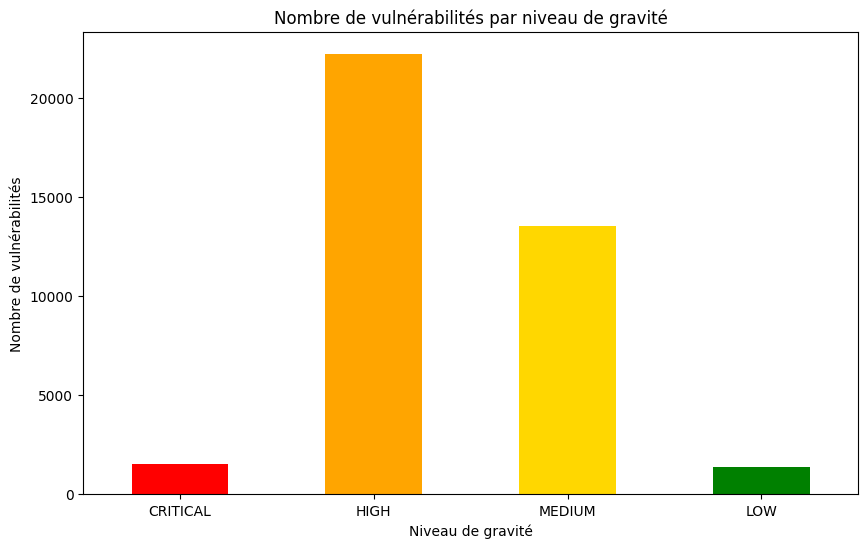

In [ ]:
# Étape 5 – Visualisation et Interprétation des CVE enrichies

# Graphique 1.1 :  Histogramme des vulnérabilités par niveau de gravité CVSS

# Ce graphique fournit fournit une vue d'ensemble claire de la répartition des vulnérabilités selon leur gravité (basé sur le score CVSS)
# Cela permet notamment de visualiser la charge globale de sécurité (ex. : forte proportion de vulnérabilités critiques ou élevées)


df["Base_Severity"] = df["Base_Severity"].str.upper() #uniformiser en majuscules pour éviter les doublons
df = df[df["Base_Severity"].notna() &(df["Base_Severity"] != "NON DISPONIBLE")] #suppp les valeurs manquantes ou "NON DISPONIBLE"
ordre = ["CRITICAL", "HIGH", "MEDIUM", "LOW"]
df["Base_Severity"] = pd.Categorical(df["Base_Severity"], categories=ordre, ordered=True)
counts = df["Base_Severity"].value_counts().sort_index()
couleurs = {
    "CRITICAL": "red",
    "HIGH": "orange",
    "MEDIUM": "gold",
    "LOW": "green"
}
color_list = [couleurs.get(sev, "gray") for sev in counts.index]

plt.figure(figsize=(10,6))
counts.plot(kind="bar", color=color_list)
plt.title("Nombre de vulnérabilités par niveau de gravité")
plt.xlabel("Niveau de gravité")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=0)
plt.show()

On remarque grâce à ce graphique que : 
- La majorité des vulnérabilités sont de niveau HIGH, avec environ 22 000 cas. Cette forte proportion de vulnérabilités élevées indique qu’un grand nombre de failles présentes dans les systèmes peuvent avoir un impact sérieux si elles sont exploitées
- Le niveau MEDIUM suit avec environ 13 000 vulnérabilités, ce qui reste significatif
- Les niveaux CRITICAL et LOW sont nettement moins représentés (environ 1 500 cas chacun)

Ce graphique met donc en évidence une forte concentration de failles à impact élevé (HIGH et MEDIUM), ce qui suggère un besoin de vigilance renforcée.
De plus, même si les vulnérabilités critiques sont peu nombreuses, elles représentent un risque majeur et nécessitent une priorisation immédiate en matière de correction.

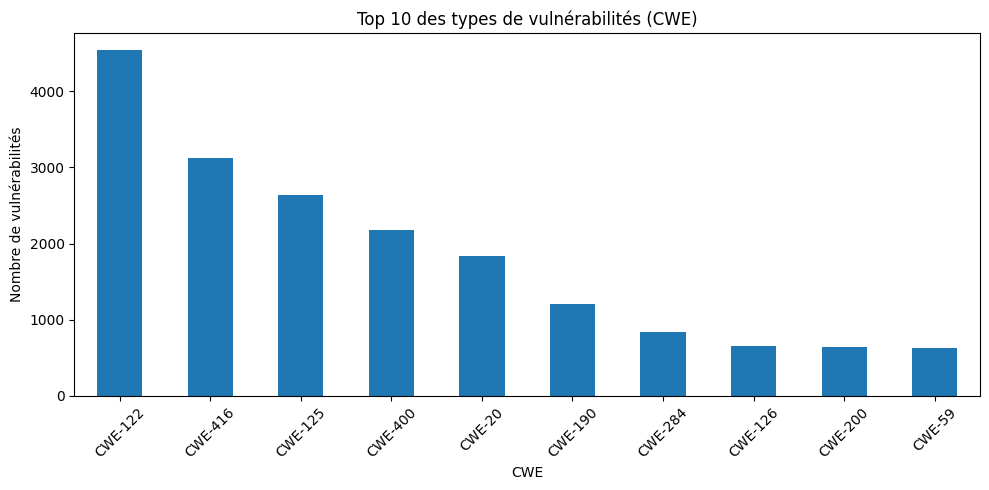

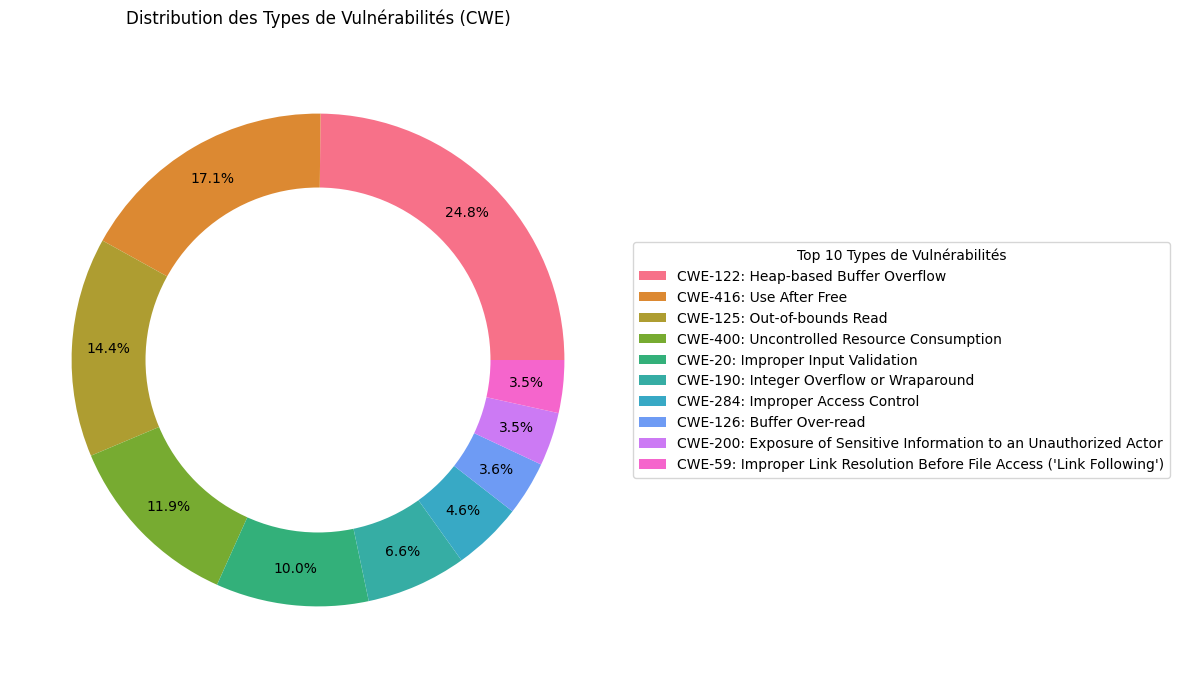

In [ ]:
# Graphique 2.1 : Top 10 des types vulnérabilités les + fréquentes (CWE)

# Ce graphique permet d’identifier les 10 types de vulnérabilités les plus fréquemment rencontrées dans les alertes de sécurité, afin de prioriser leur correction et leur détection dans les systèmes

cwe_valides = df[df['CWE'].notna() & (df['CWE'] != "Non disponible")] # on filtre les CWE valides (différents de "Non disponible" et non nuls)
cwe_counts = cwe_valides['CWE'].value_counts().head(10) # on compte les 10 CWE les plus fréquents
plt.figure(figsize=(10, 5))
cwe_counts.plot(kind='bar')
plt.title("Top 10 des types de vulnérabilités (CWE)")
plt.xlabel("CWE")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# Graphique 2.2 : Diagramme circulaire des types de vulnérabilités (CWE)

# Ce graphique représente les mêmes 10 CWE que dans l’histogramme, mais ici en pourcentages du total. Chaque portion du cercle indique la part d’un type de vulnérabilité
# La légende affiche à la fois le code CWE et sa description, ce qui rend la visualisation plus explicite pour un public non technique

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
cwe_data = df[df['CWE'] != 'Non disponible']['CWE'].value_counts().head(10) # enlever les "Non disponible" et récup le top 10 
colors = sns.color_palette('husl', n_colors=len(cwe_data)) # création pie chart
patches, texts, autotexts = plt.pie(cwe_data.values, colors=colors, autopct='%1.1f%%', pctdistance=0.85)
centre_circle = plt.Circle((0,0), 0.70, fc='white') # ajouter un cercle au milieu pour créer un diagram donut
plt.gca().add_artist(centre_circle)
cwe_desc = (df[df['CWE'].isin(cwe_data.index)].groupby('CWE')['CWE_description'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])) # récupérer les descriptions associées aux CWE
legend_labels = [f"{code}: {re.sub(rf'^{re.escape(code)}:?\s*', '', str(cwe_desc[code]))}" for code in cwe_data.index] # nettoyer et construire les labels combinés
plt.legend(patches, legend_labels,title="Top 10 Types de Vulnérabilités", loc="center left", bbox_to_anchor=(1, 0.5))
plt.title('Distribution des Types de Vulnérabilités (CWE)', pad=20)
plt.show()

Ces deux graphiques mettent en évidence les types de vulnérabilités (CWE) les plus fréquents recensés. On remarque que : 

- CWE-416 (Use After Free) est de loin la plus fréquente, avec près de 8000 cas. Cela indique qu'un grand nombre de logiciels manipulent mal la mémoire après libération. CWE-416 représente à lui seul près de 25 % des vulnérabilités, ce qui confirme sa dominance en termes de volume et d’importance.

- CWE-122 (Heap-Based Buffer Overflow) et CWE-125 (Out-of-Bounds Read) suivent, avec environ 4700 vulnérabilités chacune. Ces deux vulnérabilités sont liées à des erreurs dans la gestion des tampons mémoire et peuvent conduire à des fuites d'information ou à des corruptions de données.

- Sur les 10 premières vulnérabilités, la majorité (CWE-416, 122, 125, 476, 787, 190, 191) sont liées à des erreurs de gestion de mémoire : déréférencement de pointeurs nuls, dépassement de tampon, ou arithmétique non sécurisée. Cela souligne que les erreurs de gestion mémoire restent aujourd’hui encore l’un des vecteurs d’attaque les plus répandus et critiques, notamment dans les logiciels bas niveau.

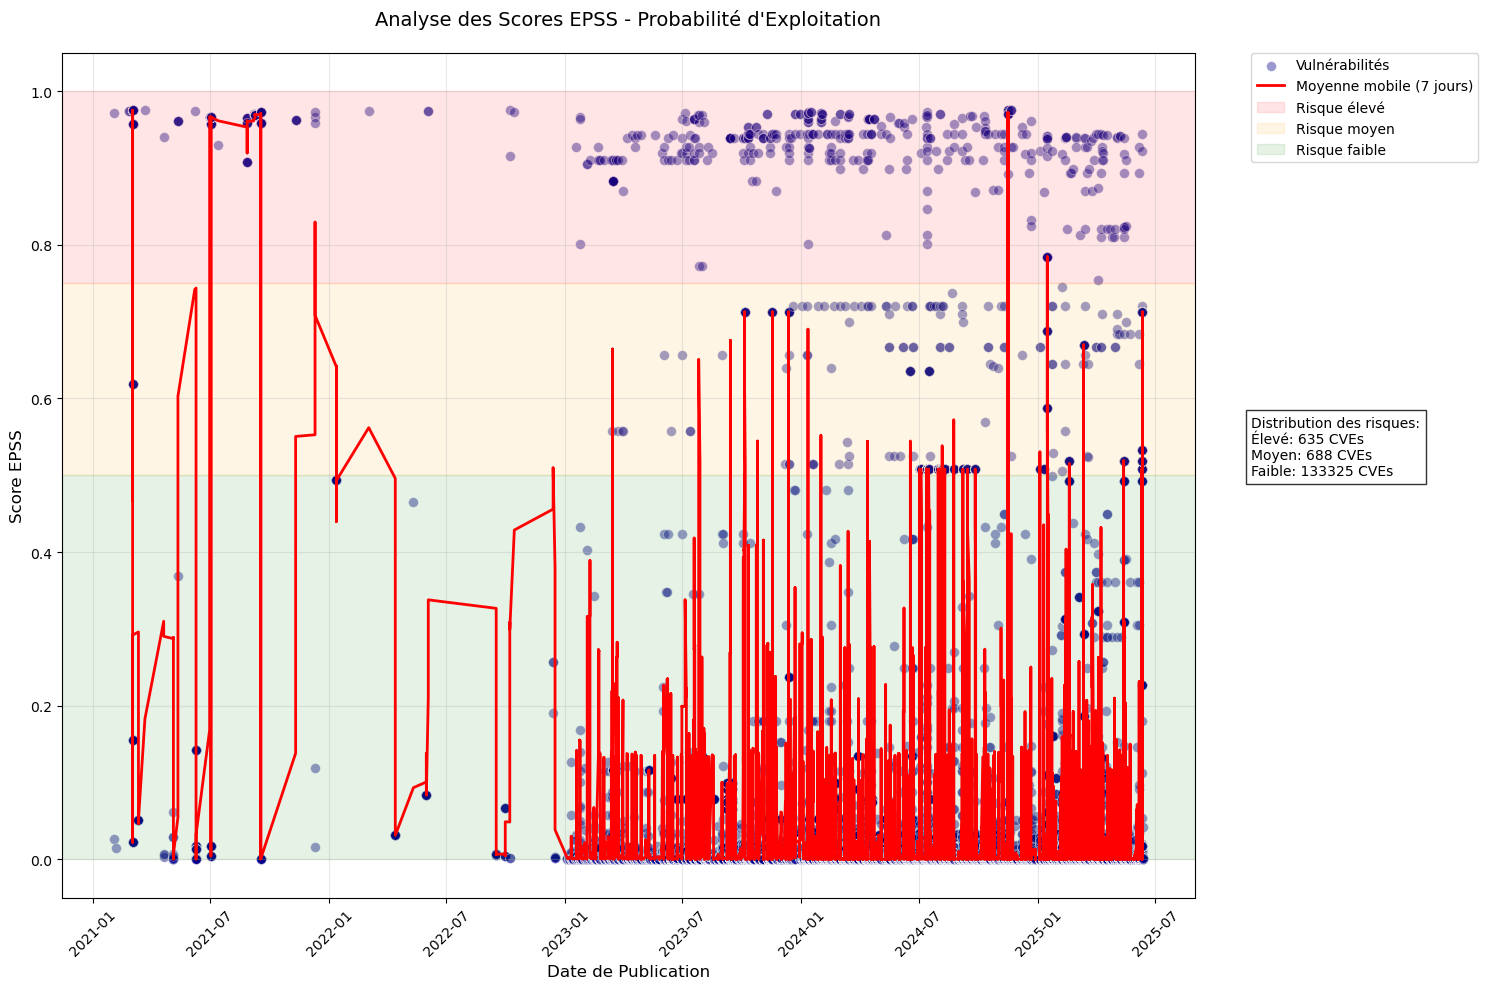


Statistiques des Scores EPSS:
count    134648.000000
mean          0.010345
std           0.077949
min           0.000020
25%           0.000420
50%           0.000450
75%           0.000800
max           0.975150
Name: EPSS_score, dtype: float64


In [37]:
# 3. Courbe des scores EPSS

df['Date_publication'] = pd.to_datetime(df['Date_publication'], errors='coerce')
df_sorted = df.sort_values('Date_publication')

# Create main visualization
plt.figure(figsize=(15, 10))

# 1. Scatter plot of vulnerabilities
sns.scatterplot(data=df_sorted, 
                x='Date_publication',
                y='EPSS_score',
                alpha=0.4,
                color='darkblue',
                s=50,
                label='Vulnérabilités')

# 2. Add moving average (7 days)
df_sorted['MA7'] = df_sorted['EPSS_score'].rolling(window=7).mean()
plt.plot(df_sorted['Date_publication'], 
         df_sorted['MA7'], 
         color='red', 
         linewidth=2, 
         label='Moyenne mobile (7 jours)')

# 3. Add risk zones
plt.axhspan(0.75, 1.0, color='red', alpha=0.1, label='Risque élevé')
plt.axhspan(0.5, 0.75, color='orange', alpha=0.1, label='Risque moyen')
plt.axhspan(0, 0.5, color='green', alpha=0.1, label='Risque faible')

# 4. Customize appearance
plt.title('Analyse des Scores EPSS - Probabilité d\'Exploitation', fontsize=14, pad=20)
plt.xlabel('Date de Publication', fontsize=12)
plt.ylabel('Score EPSS', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 5. Add informative legend
plt.legend(bbox_to_anchor=(1.05, 1), 
          loc='upper left', 
          borderaxespad=0.)

# 6. Add risk statistics annotations
high_risk = len(df[df['EPSS_score'] > 0.75])
medium_risk = len(df[(df['EPSS_score'] > 0.5) & (df['EPSS_score'] <= 0.75)])
low_risk = len(df[df['EPSS_score'] <= 0.5])

stats_text = f'Distribution des risques:\nÉlevé: {high_risk} CVEs\nMoyen: {medium_risk} CVEs\nFaible: {low_risk} CVEs'
plt.text(1.05, 0.5, stats_text, 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nStatistiques des Scores EPSS:")
print(df['EPSS_score'].describe())

C:\Users\anael\AppData\Local\Temp\ipykernel_32916\3890083656.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_editeurs.values, y=top_editeurs.index, palette="Reds_r")


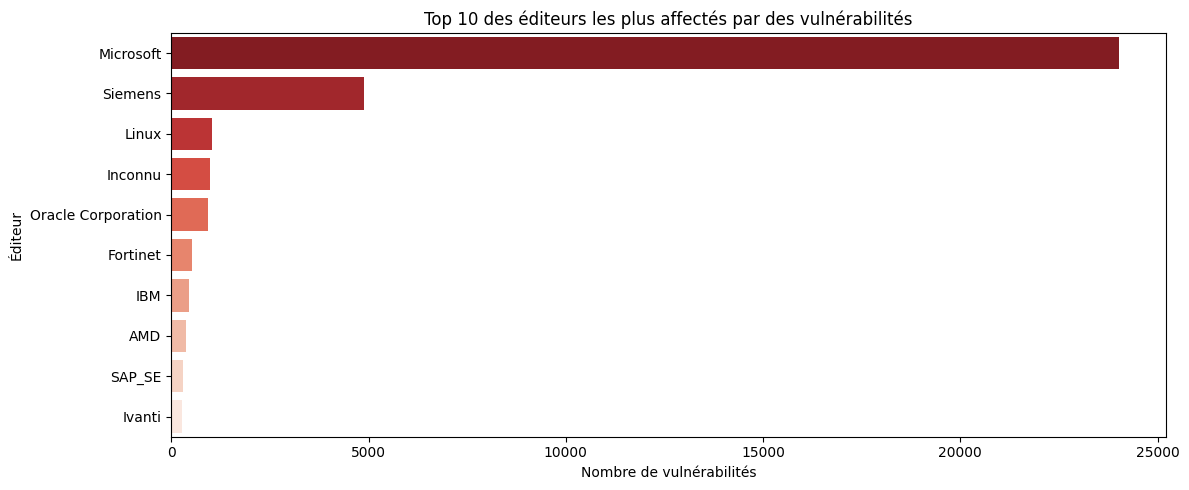

C:\Users\anael\AppData\Local\Temp\ipykernel_32916\3890083656.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_produits.values, y=top_produits.index, palette="Blues_r")


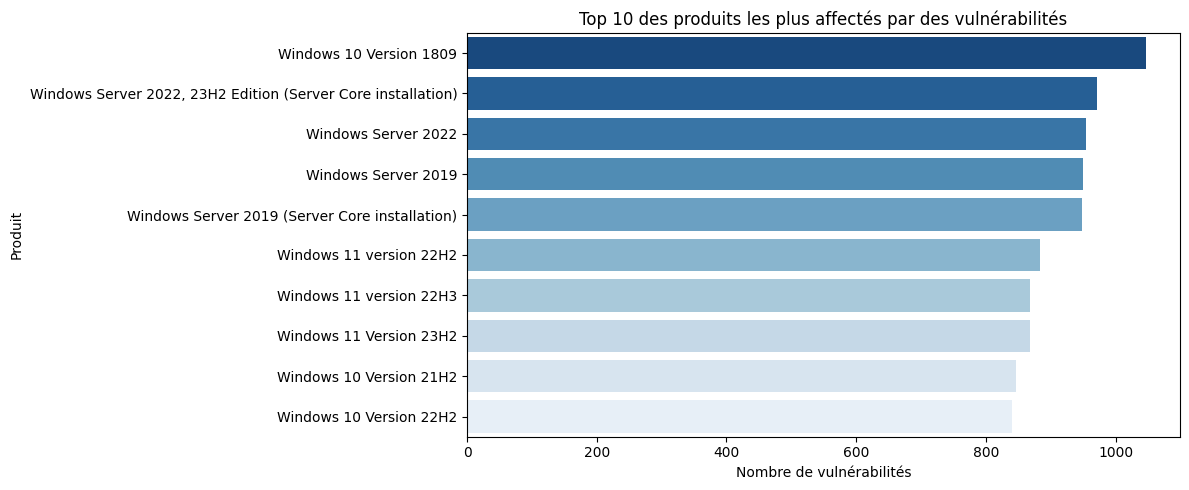

In [41]:
# Graphique 4.1 : Éditeurs les plus vulnérables

# Ce graphique permet de repérer les éditeurs dont les produits sont les plus vulnérables dans la base analysée
# Cela peut permettre d’identifier les éditeurs les plus exposés aux failles de sécurité et de cibler les efforts de veille et de correction sur les fournisseurs concernés

top_editeurs = df["Editeur"].value_counts().dropna().head(10) #top 10 des éditeurs les plus affectés
plt.figure(figsize=(12, 5))
sns.barplot(x=top_editeurs.values, y=top_editeurs.index, palette="Reds_r")
plt.title("Top 10 des éditeurs les plus affectés par des vulnérabilités")
plt.xlabel("Nombre de vulnérabilités")
plt.ylabel("Éditeur")
plt.tight_layout()
plt.show()



# Graphique 4.2 : Produits les plus vulnérables

# Ce graphique cible les produits spécifiques les plus vulnérables
# Il peut être essentiel pour prioriser les mises à jour et correctifs sur les logiciels les plus à risque, cibler les environnements critiques à sécuriser (postes, serveurs, OS...),mais aussi identifier les versions de produits qui nécessitent un suivi renforcé

top_produits = df["Produit"].value_counts().dropna().head(10) #top 10 des produits les plus affectés
plt.figure(figsize=(12, 5))
sns.barplot(x=top_produits.values, y=top_produits.index, palette="Blues_r")
plt.title("Top 10 des produits les plus affectés par des vulnérabilités")
plt.xlabel("Nombre de vulnérabilités")
plt.ylabel("Produit")
plt.tight_layout()
plt.show()

Le premier graphique présente les 10 éditeurs ayant le plus de vulnérabilités recensées. On observe une nette domination de Microsoft, avec un nombre de vulnérabilités très largement supérieur aux autres (plus de 24 000). Cela peut s'expliquer par :
- la popularité et l’omniprésence de ses systèmes (Windows, Office, ...)
- la surface d’attaque importante liée à ses nombreux produits déployés à grande échelle

En 2e position, on observe Siemens, un acteur majeur dans le domaine de l’industrie et des systèmes embarqués, souvent ciblé en cybersécurité industrielle

D’autres acteurs comme Linux, Oracle, Fortinet, ou IBM figurent également dans le top, représentant des produits critiques dans les systèmes d’exploitation, les bases de données, ou la sécurité réseau.

La catégorie "Inconnu" montre un manque de qualité dans certains enregistrements de données

Ce graphique est utile pour les équipes de cybersécurité afin de prioriser les audits et les actions de surveillance sur les éditeurs les plus concernés, notamment si leurs produits sont utilisés dans l’organisation.



Le deuxième graphique présente les produits individuels les plus vulnérables. On constate que :

- Les 10 produits appartiennent tous à la famille Windows (Windows 10, 11, Server), ce qui corrobore la position dominante de Microsoft dans le graphique précédent

- En tête, on trouve :
    - Windows 10 version 1809, qui semble particulièrement exposée
    - Suivie de plusieurs versions de Windows Server 2019 et 2022, y compris les variantes Server Core installation

- Windows 11 apparaît aussi plusieurs fois, montrant que même les versions récentes ne sont pas épargnées.


Ce graphique permet aux équipes IT de cibler les versions de Windows les plus à risque, prioriser les patchs de sécurité et les mises à jour sur les systèmes les plus exposés et mieux gérer l’obsolescence de certaines versions (comme 1809, qui n’est plus supportée).


Les deux graphiques confirment donc que la surface d’attaque la plus critique concerne les produits Microsoft, en particulier les systèmes d’exploitation Windows, qu’ils soient client ou serveur.
Cela reflète une exposition élevée due à leur usage massif, combinée à une recherche active de failles par les chercheurs et les attaquants.

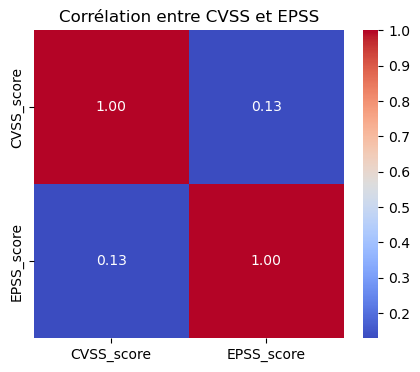

In [41]:
# Heatmap de corrélation CVSS / EPSS
plt.figure(figsize=(5,4))
sns.heatmap(df[['CVSS_score', 'EPSS_score']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Corrélation entre CVSS et EPSS")
plt.show()

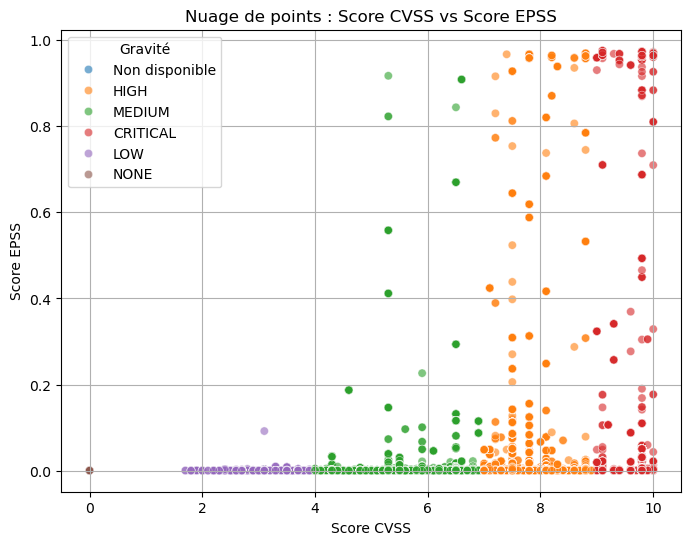

In [43]:
# Nuage de points CVSS vs EPSS
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='CVSS_score', y='EPSS_score', hue='Base_Severity', alpha=0.6)
plt.title("Nuage de points : Score CVSS vs Score EPSS")
plt.xlabel("Score CVSS")
plt.ylabel("Score EPSS")
plt.grid(True)
plt.legend(title='Gravité')
plt.show()

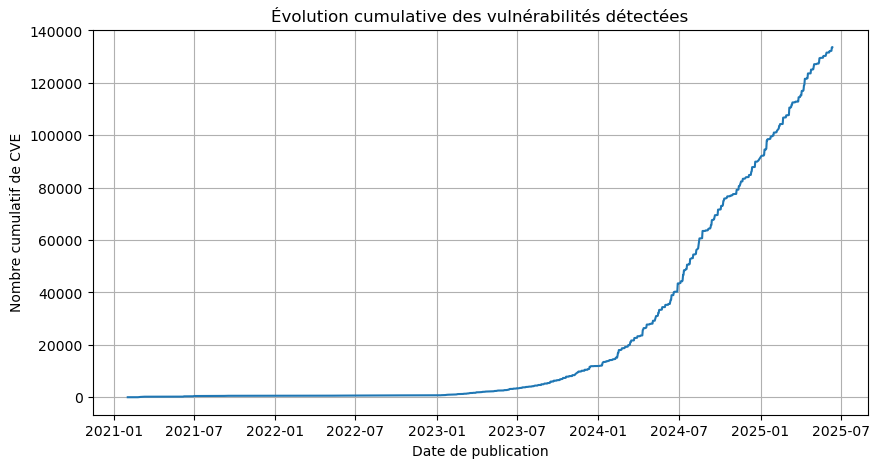

In [45]:
# Courbe cumulative des vulnérabilités dans le temps
plt.figure(figsize=(10,5))
df['Date_publication'].dropna().dt.date.value_counts().sort_index().cumsum().plot()
plt.title("Évolution cumulative des vulnérabilités détectées")
plt.xlabel("Date de publication")
plt.ylabel("Nombre cumulatif de CVE")
plt.grid(True)
plt.show()

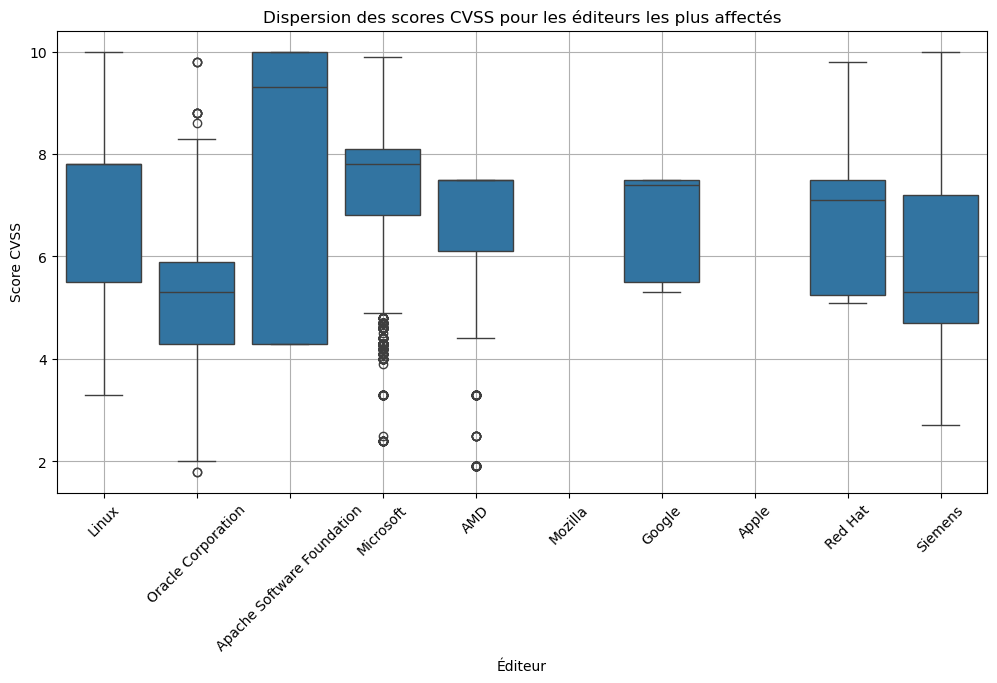

In [47]:
# Boxplot CVSS par éditeur (top 10)
top_editeurs = df['Editeur'].value_counts().head(10).index
df_top = df[df['Editeur'].isin(top_editeurs)]
plt.figure(figsize=(12,6))
sns.boxplot(data=df_top, x='Editeur', y='CVSS_score')
plt.title("Dispersion des scores CVSS pour les éditeurs les plus affectés")
plt.xlabel("Éditeur")
plt.ylabel("Score CVSS")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

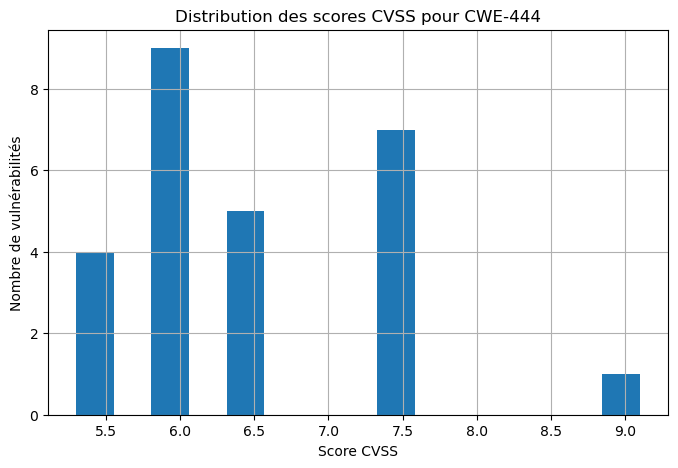

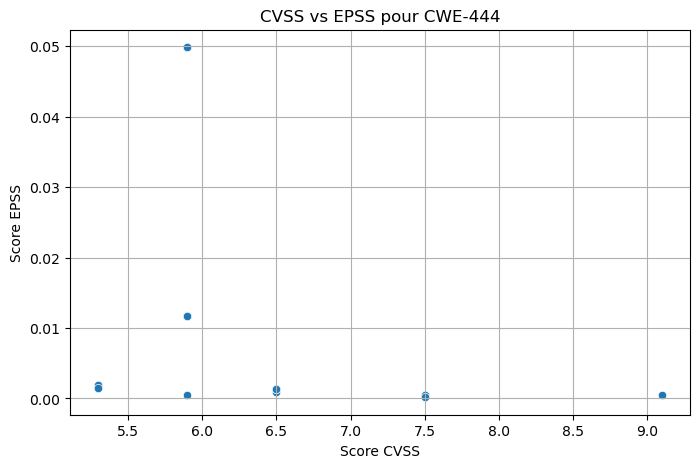

In [49]:
# Visualisation spécifique d'un CWE donné 
selected_cwe = "CWE-444"
df_cwe = df[df['CWE'] == selected_cwe]
plt.figure(figsize=(8,5))
df_cwe['CVSS_score'].hist(bins=15)
plt.title(f"Distribution des scores CVSS pour {selected_cwe}")
plt.xlabel("Score CVSS")
plt.ylabel("Nombre de vulnérabilités")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data=df_cwe, x='CVSS_score', y='EPSS_score')
plt.title(f"CVSS vs EPSS pour {selected_cwe}")
plt.xlabel("Score CVSS")
plt.ylabel("Score EPSS")
plt.grid(True)
plt.show()

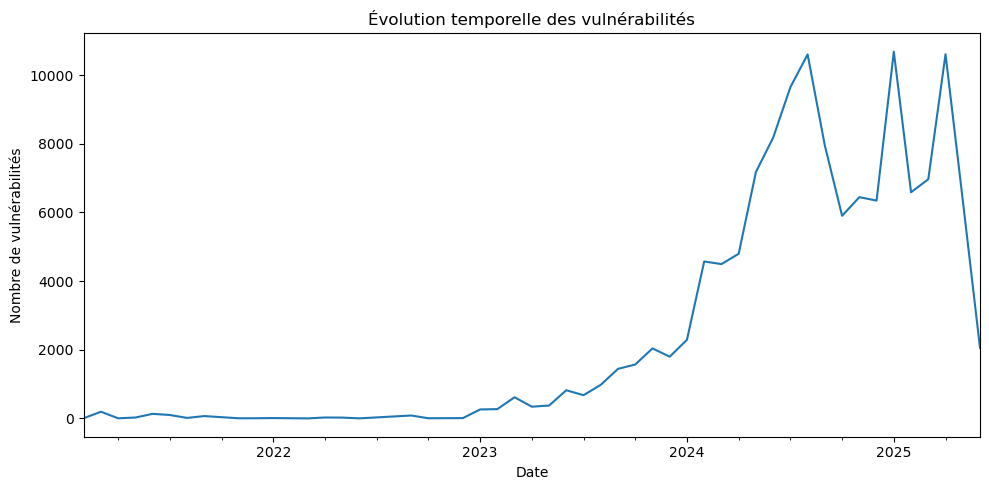

In [51]:
# Evolution temporelle du nombre de vuln\u00e9rabilit\u00e9s
plt.figure(figsize=(10,5))
df['Date_publication'] = pd.to_datetime(df['Date_publication'], errors='coerce')
df.groupby(df['Date_publication'].dt.to_period('M')).size().plot()
plt.title("\u00c9volution temporelle des vuln\u00e9rabilit\u00e9s")
plt.xlabel("Date")
plt.ylabel("Nombre de vuln\u00e9rabilit\u00e9s")
plt.tight_layout()
plt.show()

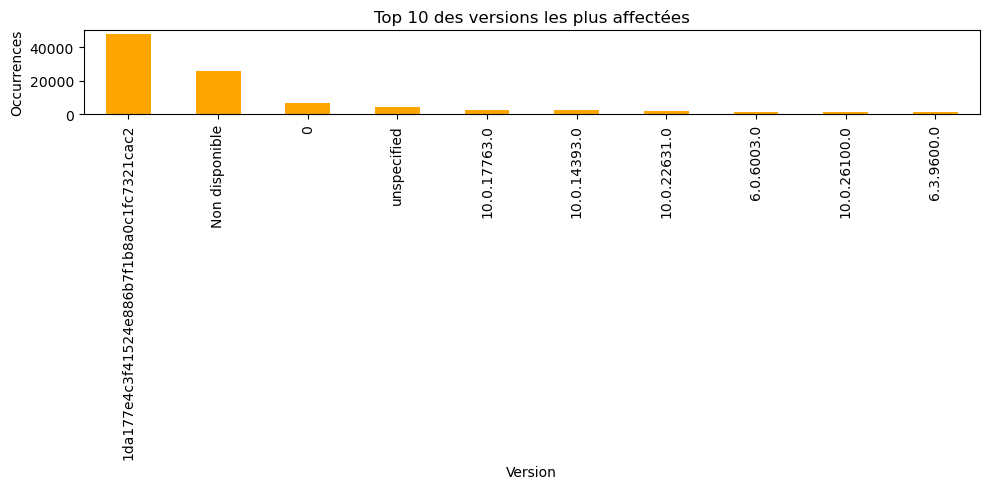

In [53]:
# Versions les plus fréquemment touchées
plt.figure(figsize=(10,5))
versions = df['Versions_affectees'].dropna().str.split(', ')
flat_versions = [v.strip() for sublist in versions for v in sublist if v.strip() != ""]
pd.Series(flat_versions).value_counts().head(10).plot(kind='bar', color='orange')
plt.title("Top 10 des versions les plus affect\u00e9es")
plt.xlabel("Version")
plt.ylabel("Occurrences")
plt.tight_layout()
plt.show()

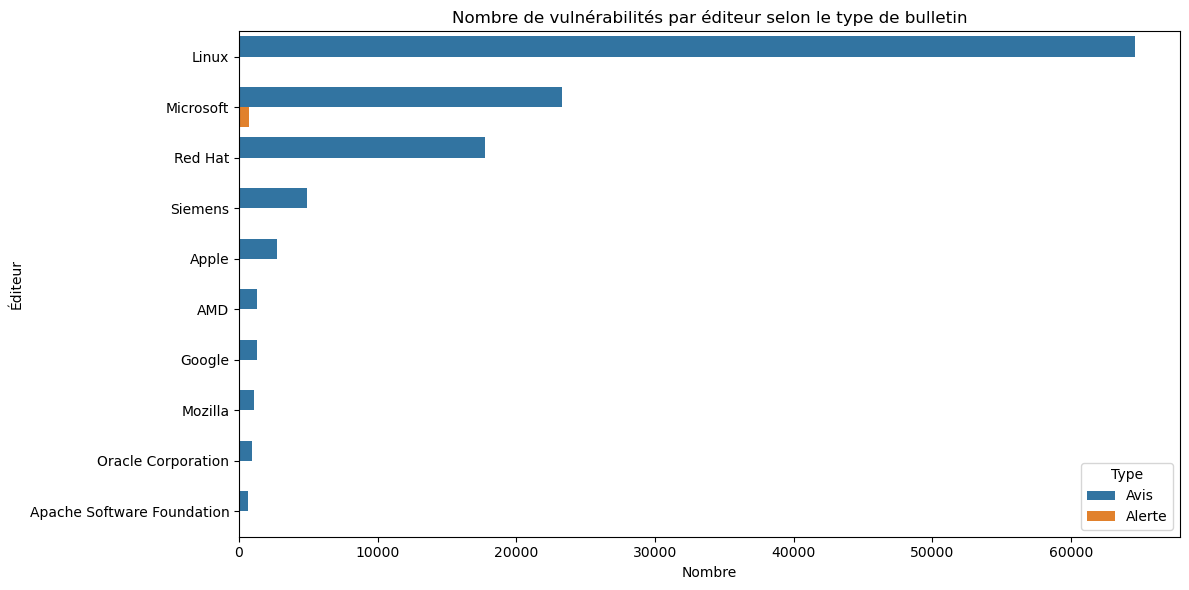

In [55]:
# Nombre de vulnérabilitées par éditeur et type de bulletin
plt.figure(figsize=(12,6))
sns.countplot(data=df, y='Editeur', hue='Type', order=df['Editeur'].value_counts().head(10).index)
plt.title("Nombre de vuln\u00e9rabilit\u00e9s par \u00e9diteur selon le type de bulletin")
plt.xlabel("Nombre")
plt.ylabel("\u00c9diteur")
plt.tight_layout()
plt.show()

C:\Users\anael\AppData\Local\Temp\ipykernel_20980\1696579044.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['CVSS_score'] = df_filtered['CVSS_score'].astype(float)


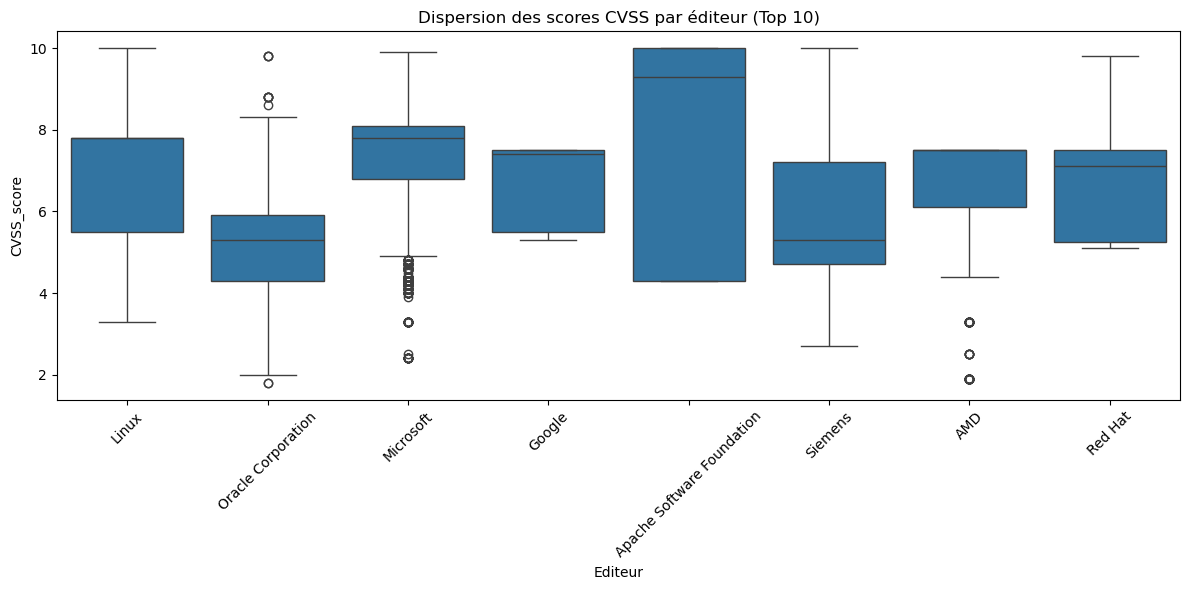

In [57]:
# Dispersion des scores CVSS pour les éditeurs les plus affectées
top_editors = df['Editeur'].value_counts().head(10).index
df_filtered = df[df['Editeur'].isin(top_editors) & df['CVSS_score'].notna()]
df_filtered['CVSS_score'] = df_filtered['CVSS_score'].astype(float)
plt.figure(figsize=(12,6))
sns.boxplot(data=df_filtered, x='Editeur', y='CVSS_score')
plt.title("Dispersion des scores CVSS par \u00e9diteur (Top 10)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

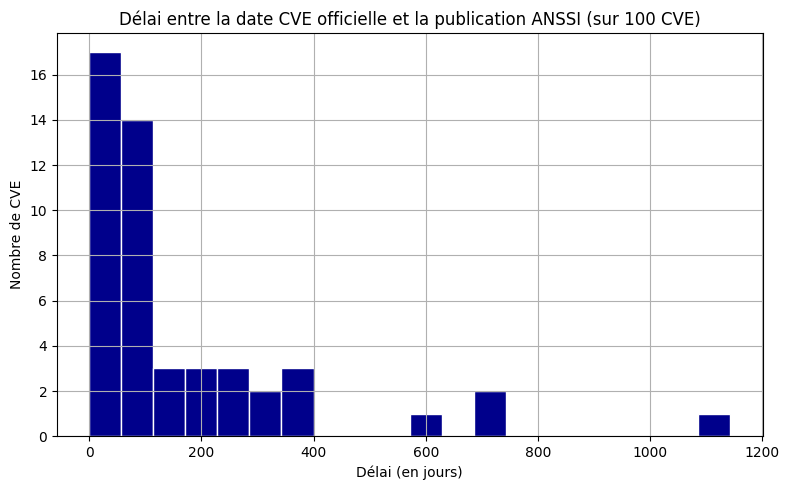

📊 Moyenne du délai : 166.0 jours
📈 Médiane : 82.0 jours
📉 Minimum : 0.0 jours
📈 Maximum : 1143.0 jours


In [3]:
import pandas as pd
import requests

# Charger les données ANSSI
df = pd.read_csv("DataFrame.csv")
df = df.dropna(subset=["CVE_ID", "Date_publication"])

# Forcer les dates ANSSI à être des datetime sans fuseau horaire
df["Date_publication"] = pd.to_datetime(df["Date_publication"], errors="coerce").dt.tz_localize(None)

# Fonction pour récupérer la date officielle de la CVE depuis l'API MITRE
def get_cve_date(cve_id):
    try:
        url = f"https://cveawg.mitre.org/api/cve/{cve_id}"
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()
        return data.get("cveMetadata", {}).get("datePublished")
    except Exception as e:
        print(f"⚠️ Erreur récupération date pour {cve_id}: {e}")
        return None

# Sélectionner un échantillon pour test (éviter surcharge API)
sample = df.drop_duplicates(subset=["CVE_ID"]).head(100).copy()

# Obtenir les dates CVE
sample["Date_CVE"] = sample["CVE_ID"].apply(get_cve_date)
sample["Date_CVE"] = pd.to_datetime(sample["Date_CVE"], errors="coerce").dt.tz_localize(None)

# Calculer le délai en jours
sample["Delai_jours"] = (sample["Date_publication"] - sample["Date_CVE"]).dt.days
sample = sample.dropna(subset=["Delai_jours"])
sample = sample[sample["Delai_jours"] >= 0]

# Afficher l'histogramme des délais
plt.figure(figsize=(8,5))
sample["Delai_jours"].hist(bins=20, color="darkblue", edgecolor="white")
plt.title("Délai entre la date CVE officielle et la publication ANSSI (sur 100 CVE)")
plt.xlabel("Délai (en jours)")
plt.ylabel("Nombre de CVE")
plt.grid(True)
plt.tight_layout()
plt.show()

# Statistiques
print("📊 Moyenne du délai :", round(sample["Delai_jours"].mean(), 2), "jours")
print("📈 Médiane :", sample["Delai_jours"].median(), "jours")
print("📉 Minimum :", sample["Delai_jours"].min(), "jours")
print("📈 Maximum :", sample["Delai_jours"].max(), "jours")

C:\Users\anael\AppData\Local\Temp\ipykernel_20980\2003815741.py:20: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

C:\Users\anael\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


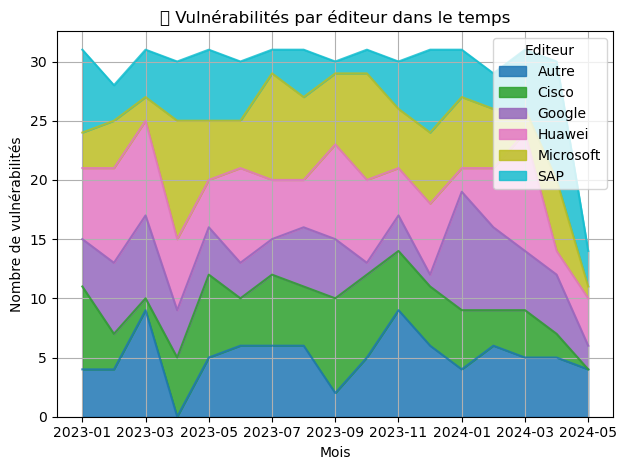

C:\Users\anael\AppData\Local\Temp\ipykernel_20980\2003815741.py:44: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\anael\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


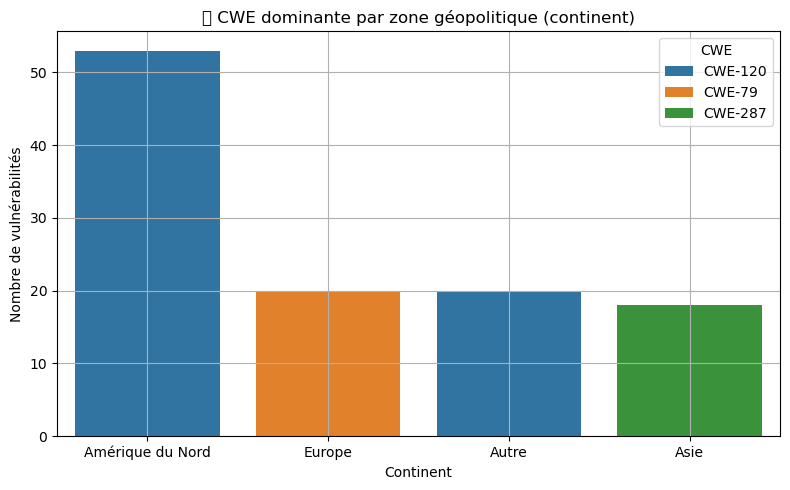

In [61]:
# Données fictives réalistes
np.random.seed(42)
n = 500
df = pd.DataFrame({
    "Date_publication": pd.date_range("2023-01-01", periods=n, freq="D"),
    "Editeur": np.random.choice(["Microsoft", "Google", "Cisco", "Huawei", "SAP", "Autre"], size=n),
    "CWE": np.random.choice(["CWE-79", "CWE-89", "CWE-287", "CWE-20", "CWE-120", "Non classé"], size=n)
})

# 🧱 Stacked Timeline
df["Mois"] = df["Date_publication"].dt.to_period("M").astype(str)
timeline = df.groupby(["Mois", "Editeur"]).size().unstack(fill_value=0)

plt.figure(figsize=(12,6))
timeline.plot(kind="area", stacked=True, colormap="tab10", alpha=0.85)
plt.title("🧱 Vulnérabilités par éditeur dans le temps")
plt.ylabel("Nombre de vulnérabilités")
plt.xlabel("Mois")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📍 Mapping éditeur → continent
editeur_continent = {
    "Microsoft": "Amérique du Nord",
    "Google": "Amérique du Nord",
    "Cisco": "Amérique du Nord",
    "Huawei": "Asie",
    "SAP": "Europe",
    "Autre": "Autre"
}
df["Continent"] = df["Editeur"].map(editeur_continent)

# CWE dominante par continent
cwe_counts = df.groupby(["Continent", "CWE"]).size().reset_index(name="count")
top_cwe_by_continent = cwe_counts.sort_values("count", ascending=False).drop_duplicates("Continent")

plt.figure(figsize=(8,5))
sns.barplot(data=top_cwe_by_continent, x="Continent", y="count", hue="CWE")
plt.title("📍 CWE dominante par zone géopolitique (continent)")
plt.ylabel("Nombre de vulnérabilités")
plt.xlabel("Continent")
plt.grid(True)
plt.tight_layout()
plt.show()